In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
from matplotlib.dates import DateFormatter

In [3]:
# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
date_form = DateFormatter("%-d")

In [4]:
def load_systems_data(degradation_setting, rain_scenario, file_type="concentrations"):
    if file_type=="concentrations":
        df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", f"{degradation_setting}_{rain_scenario}.csv"))
        df_res = df_res.loc[df_res.minutes>0,:]
    elif file_type=="flow_rates":
        df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", f"flow_rates_{degradation_setting}_{rain_scenario}.csv"))
        df_res.minutes = df_res.minutes - 70 # ensure time consistency with concentrations
        df_res = df_res.loc[df_res.minutes>0,:]
    else:
        assert False, f"file_type {file_type} not supported"

    df_res.time = pd.to_datetime(df_res.time)

    # drop MW064, RW156 (invalid calculations of ++systems)
    df_res = df_res.loc[~df_res.sampling_point.isin(["MW064", "RW156"]), :]
    # rename sampling locations according to naming in the paper
    df_res.sampling_point = df_res.sampling_point.map({"MW022": "1", "MW023": "2", "MW017": "3", "MW043": "4", "MW048": "5", 
                        "RW157": "6", "MW046": "7", "MW061": "8", "RW143": "9", "RW141": "10",
                        "RW155": "11", "MW059": "12", "RW211": "13", "MW054": "14",
                        "RW126": "15", "MW052": "16"})
    return df_res

In [5]:
df_conc = load_systems_data("no_degradation", "KeinRegen", file_type="concentrations")

### Tidy memilio data: time since transmission & location per agent and timepoint

In [6]:
def get_systems_location(df_locations, memilio_location):
    locs = df_locations.loc[df_locations.memilio_locations.apply(lambda locations: memilio_location in locations), "systems_location"]
    if len(locs) > 1:
        print(f"Warning: Multiple locations found for {memilio_location}: {locs}")
    return locs.iloc[0]

In [7]:
def load_infection_path_information(simulation_id, experiment_series="MEmilio Output - 03 April 2024"):
    """
    This function loads the infection path information from the MEmilio output and returns a tidied version of it.

    Parameters
    ----------
    simulation_id : int
        identifier of memilio simulation
    experiment_series : str
        name of the experiment series in which the simulation was run

    Returns
    -------
    pd.DataFrame
        with columns agent_id, t_exposed (time span of exposure), t_infected (time span of infection), hospitalized (whether or not the agent was hospitalized)
    """
    # read in infection paths
    infection_paths = pd.read_csv(f"memilio_output/{experiment_series}/{simulation_id}_infection_paths.txt", header=0, index_col=None, sep=" ").reset_index()
    new_cols = infection_paths.columns[1:].to_list()
    new_cols.append("bla")
    infection_paths.columns = new_cols
    infection_paths = infection_paths.drop(columns="bla")

    # infection duration
    infection_paths["t_infected"] = infection_paths["E"] + infection_paths["I_ns"] + infection_paths["I_sy"] + infection_paths["I_sev"] + infection_paths["I_cri"]
    infection_paths["hospitalized"] = infection_paths["I_sev"] + infection_paths["I_cri"] > 0

    # For the shedding curve, we only need the agent id, duration of infection, the duration of exposure, and whether the agent was hospitalized
    infection_paths = infection_paths[["Agent_id", "E", "t_infected", "hospitalized"]]
    infection_paths.columns = ["agent_id", "t_exposed", "t_infected", "hospitalized"]
    
    # change time scale to days
    infection_paths[["t_exposed", "t_infected"]] = infection_paths[["t_exposed", "t_infected"]] / 24

    return infection_paths

In [5]:
simulation_id = 1
infection_path = load_infection_path_information(simulation_id)
infection_path.head()

,agent_id,t_exposed,t_infected,hospitalized
0,0,0.0,0.0,False
1,1,0.0,0.0,False
2,2,0.0,0.0,False
3,3,0.0,0.0,False
4,4,0.0,0.0,False


In [155]:
# agents that are infected at some point
infected_agents = infection_path.loc[infection_path.t_infected>0, "agent_id"].to_list()

In [8]:
def tidy_memilio_output_file(simulation_id, experiment_series="MEmilio Output - 03 April 2024"):
    """
    This function loads the output.txt information from the MEmilio simulation result and returns a tidied version of it.

    Parameters
    ----------
    simulation_id : int
        identifier of memilio simulation
    experiment_series : str
        name of the experiment series in which the simulation was run

    Returns
    -------
    pd.DataFrame
        with columns
        - systems_location: location of the agent
        - agent_id: identifier of the agent
        - time_in_hours: simulation time (hours)
        - time_in_days simulation time (days)
        - time_since_transmission: time since transmission of the agent in hours
        - simulation_id: identifier of the memilio simulation
    """
        
    # Load location mapping information and transform it to tidy data
    df_locations = pd.read_csv(f"memilio_output/{experiment_series}/{simulation_id}_location_mapping.txt", index_col=None, header=None)
    df_locations["systems_location"] = df_locations.apply(lambda row: row.iloc[0].split(" ")[0].zfill(5), axis=1)
    df_locations["memilio_locations"] = df_locations.apply(lambda row: row.iloc[0].split(" ")[1:], axis=1)
    df_locations["memilio_locations"] = df_locations.memilio_locations.apply(lambda x: [i for i in x if i != ""])
    df_locations = df_locations[['systems_location', 'memilio_locations']]

    # preprocessing of output.txt
    df = pd.read_csv(f"memilio_output/{experiment_series}/{simulation_id}_output.txt", header=None)
    # add location information
    df["memilio_location"] = df.apply(lambda row: row.iloc[0].split(" ")[0], axis=1)
    df.loc[1:,"systems_location"] = df["memilio_location"].iloc[1:].apply(lambda x: get_systems_location(df_locations, x))
    df.loc[df.memilio_location=="1000", "systems_location"] = "graveyard"


    # create new dataframe that contains information about the agent location and time since transmission for each timepoint
    # df_tidy = pd.DataFrame()

    def get_df_sub_from_row(row_output):
        df_sub = pd.DataFrame()
        n_timesteps = int(row_output[0].split(" ")[1])
        output = row_output[0].split(" ")[2:]
        systems_location = row_output["systems_location"]

        # transform
        # current timestep, number of agent, agent_id_1, time since transmission for a1, ...
        # to df with location, agent_id, t, time_since_transmission information
        for i in range(0, n_timesteps):
            # evaluate one timestep
            current_timestep = float(output[0])
            current_n_agents = int(output[1])
            n_entries = current_n_agents*2
            timestep_output = output[2:2+n_entries]
            timestep_output = [float(i) for i in timestep_output]
            times_since_transmission = timestep_output[1::2]

            df_sub = pd.concat((df_sub, pd.DataFrame({"systems_location": [systems_location]*current_n_agents, "agent_id": [int(el) for el in timestep_output[::2]], "time_in_hours": [current_timestep] * current_n_agents, "time_since_transmission": times_since_transmission})))
            output = output[2+n_entries:]
        return df_sub

    df_tidy = pd.concat(df.apply(lambda row: get_df_sub_from_row(row), axis=1).to_list())

    df_tidy["time_in_days"] = df_tidy["time_in_hours"]/24
    df_tidy["time_since_transmission"] = df_tidy["time_since_transmission"]/24
    df_tidy["simulation_id"] = simulation_id
    return df_tidy

In [10]:
tidy_memilio_output_file(simulation_id)

,systems_location,agent_id,time_in_hours,time_since_transmission,time_in_days,simulation_id
0,00013,318.0,9.0,0.208333,0.375000,1
1,00013,349.0,9.0,-0.041667,0.375000,1
0,00013,137.0,10.0,-0.041667,0.416667,1
1,00013,149.0,10.0,-0.041667,0.416667,1
2,00013,405.0,10.0,-0.041667,0.416667,1
...,...,...,...,...,...,...
1,00125,852.0,335.0,-0.041667,13.958333,1
2,00125,853.0,335.0,-0.041667,13.958333,1
0,00125,851.0,336.0,-0.041667,14.000000,1
1,00125,852.0,336.0,-0.041667,14.000000,1


In [250]:
# Attention! running this for every simulation id takes quite some time
# [tidy_memilio_output_file(simulation_id).to_csv(f"memilio_output/MEmilio Output - 03 April 2024/agent_trajectories/agent_trajectories_{simulation_id}.csv") for simulation_id in range(1, 251)]

### Generate dataframes containing the relevant infections-per-location information for each simulation

In [9]:
def get_infections_per_location(simulation_id, experiment_series="MEmilio Output - 03 April 2024"):
    # Load location mapping information and transform it to tidy data
    df_locations = pd.read_csv(f"{experiment_series}/{simulation_id}_location_mapping.txt", index_col=None, header=None)
    df_locations["systems_location"] = df_locations.apply(lambda row: row.iloc[0].split(" ")[0].zfill(5), axis=1)
    df_locations["memilio_locations"] = df_locations.apply(lambda row: row.iloc[0].split(" ")[1:], axis=1)
    df_locations["memilio_locations"] = df_locations.memilio_locations.apply(lambda x: [i for i in x if i != ""])
    df_locations = df_locations[['systems_location', 'memilio_locations']]

    # preprocessing of output.txt
    df = pd.read_csv(f"memilio_output/MEmilio Output - 03 April 2024/{simulation_id}_output.txt", header=None)
    # add location information
    df["memilio_location"] = df.apply(lambda row: row.iloc[0].split(" ")[0], axis=1)
    df.loc[1:,"systems_location"] = df["memilio_location"].iloc[1:].apply(lambda x: get_systems_location(df_locations, x))
    df.loc[df.memilio_location=="1000", "systems_location"] = "graveyard"


    # create new dataframe that contains information on the number of infections per timestep and location
    df_infections = pd.DataFrame()

    for j, row_output in df.iterrows():
        n_timesteps = int(row_output[0].split(" ")[1])
        output = row_output[0].split(" ")[2:]
        systems_location = row_output["systems_location"]

        timesteps = []
        n_infections = []
        n_agents = []
        avg_times_since_transmission = [] # of exposed agents

        # current timestep, number of agent, agent_id_1, time since transmission for a1, ...
        for i in range(0, n_timesteps):
            # evaluate one timestep
            current_timestep = float(output[0])
            timesteps.append(current_timestep)
            current_n_agents = int(output[1])
            n_entries = current_n_agents*2
            timestep_output = output[2:2+n_entries]
            timestep_output = [float(i) for i in timestep_output]
            times_since_transmission = timestep_output[1::2]
            n_infections.append(len([el for el in times_since_transmission if el>-1]))
            n_agents.append(current_n_agents)
            if n_infections[-1] == 0:
                avg_times_since_transmission.append(0)
            else:
                avg_times_since_transmission.append(np.mean([el for el in times_since_transmission if el>-1]))
            # go to next section of output
            output = output[2+n_entries:]

        df_sub = pd.DataFrame({"timestep": timesteps, "n_infections": n_infections, "n_agents": n_agents, "avg_times_since_transmission": avg_times_since_transmission})
        df_sub["systems_location"] = systems_location
        df_infections = pd.concat([df_infections, df_sub])

    df_infections["time_in_days"] = df_infections["timestep"]/24
    df_infections["avg_times_since_transmission"] = df_infections["avg_times_since_transmission"]/24
    df_infections["simulation_id"] = simulation_id
    return df_infections

In [10]:
# Attention! running this takes quite some time
"""
df_infections_total = pd.DataFrame()
for simulation_id in range(1, 251):
    df_infections = get_infections_per_location(simulation_id)
    df_infections.to_csv(f"memilio_output/preprocessed/{simulation_id}_infections_per_location.txt")
    df_infections_total = pd.concat([df_infections_total, df_infections])
df_infections_total.to_csv("memilio_output/preprocessed/combined_infections_per_location.txt")
"""

'\ndf_infections_total = pd.DataFrame()\nfor simulation_id in range(1, 251):\n    df_infections = get_infections_per_location(simulation_id)\n    df_infections.to_csv(f"memilio_output/preprocessed/{simulation_id}_infections_per_location.txt")\n    df_infections_total = pd.concat([df_infections_total, df_infections])\ndf_infections_total.to_csv("memilio_output/preprocessed/combined_infections_per_location.txt")\n'

## Visualize & analyze results

In [10]:
# Define upstream locations for three sampling points of the neighbourhood
upstream_1 = ["00083", "00084", "00085"] # ++systems areas upstream of sampling point 1
upstream_2 = ["00102", "00103"] # ++systems areas upstream of sampling point 2
upstream_3 = upstream_1 + upstream_2 + ["00086", "00087"] # ++systems areas upstream of sampling point 3

upstream_locations_dict = {"1": upstream_1, "2": upstream_2, "3": upstream_3}

In [11]:
def viral_load(t_since_transmission):
    t_start = 0
    incline = 2.0
    decline = -0.17
    peak = 8.1
    t_end = peak/incline - peak/decline

    if t_since_transmission>=t_start and t_since_transmission<=t_start+(peak/incline):
        return incline * (t_since_transmission-t_start)
    elif t_since_transmission>t_start+(peak/incline) and t_since_transmission<=t_end:
        return peak + decline*(t_since_transmission-t_start-(peak/incline))
    else:
        return 0
    

def shedding(t):
    c1 = -7
    c2 = 1
    shedding = 1/(1+np.exp(-(c1+c2*viral_load(t))))
    return shedding


def infectiousness(t_since_transmission, t_infected, t_E, hospitalized):
    t_start = 0
    kappa = 10**(7.1) 
    t_limit = 1.3
    incline = 2.0
    decline = -0.17
    peak = 8.1
    t_end = peak/incline - peak/decline

    if t_since_transmission <= 0:
        return 0

    if hospitalized:
        scale = 1
    else:
        scale = 0.75

    t_shift = t_E - t_limit

    t_s_end = t_start + t_infected

    xi = (t_end - t_start)/t_infected

    if t_start + t_shift < t_since_transmission and t_since_transmission < t_s_end:
        infectiousness = scale * kappa * shedding(xi * (t_since_transmission - t_shift - (xi-1) * t_start))
    else:
        infectiousness = 0

    return infectiousness

#### Analysis for 1 simulation

In [110]:
sampling_point = "2"
simulation_id = 2

upstream_locations = upstream_locations_dict[sampling_point]

In [111]:
# load agent trajectory data
df_agent_trajectory = pd.read_csv(f"memilio_output/MEmilio Output - 03 April 2024/agent_trajectories/agent_trajectories_{simulation_id}.csv", index_col=0)
df_agent_trajectory["systems_location"] = df_agent_trajectory["systems_location"].astype(str).apply(lambda x: x.zfill(5))
df_agent_trajectory["infected"] = df_agent_trajectory["time_since_transmission"] > 0

In [112]:
df_agent_trajectory = df_agent_trajectory.loc[df_agent_trajectory.systems_location.isin(upstream_locations), :]

# add infection path information
infection_path = load_infection_path_information(simulation_id)
df_agent_trajectory = df_agent_trajectory.merge(infection_path, on="agent_id")

# load concentration data
df_conc_sub = df_conc.loc[(df_conc.sampling_point==sampling_point) & (df_conc.memilio_id==simulation_id), :].copy()
df_conc_sub.sort_values("time", inplace=True)

In [113]:
df_agent_trajectory["t_exposed"] = df_agent_trajectory["t_exposed"].astype(float)
df_agent_trajectory["t_infected"] = df_agent_trajectory["t_infected"].astype(float)

# if transmission happened before simulation: set t_exposed to the first time since transmission and add it to total t_infected time
rel_rows = (df_agent_trajectory["time_since_transmission"]>0) & (df_agent_trajectory["t_exposed"]==0)
new_t_E = df_agent_trajectory.loc[rel_rows,:].groupby("agent_id")["time_since_transmission"].min().reset_index().rename(columns={"time_since_transmission": "t_exposed_new"})
new_t_E["t_exposed_new"] = new_t_E["t_exposed_new"]

df_agent_trajectory = df_agent_trajectory.merge(new_t_E, on="agent_id", how="left")

df_agent_trajectory.loc[rel_rows, "t_exposed"] = df_agent_trajectory.loc[rel_rows, "t_exposed_new"]
df_agent_trajectory.loc[rel_rows, "t_infected"] = df_agent_trajectory.loc[rel_rows, "t_exposed_new"] + df_agent_trajectory.loc[rel_rows, "t_infected"]

df_agent_trajectory.drop(columns="t_exposed_new", inplace=True)


# Add information about shedding
df_agent_trajectory["shedding"] = df_agent_trajectory.apply(lambda row: infectiousness(row["time_since_transmission"], row["t_infected"], row["t_exposed"], row["hospitalized"]), axis=1)

In [114]:
# number of infected agents over time
upstream_prevalence = df_agent_trajectory.groupby("time_in_days").sum()["infected"].reset_index().rename(columns={"infected": "n_infections"})

# Average time since transmission for all infected agents
avg_times_since_transmission = df_agent_trajectory.loc[df_agent_trajectory.time_since_transmission>0, :].groupby("time_in_days")["time_since_transmission"].mean().reset_index()

# Average upstream shedding for all infected agents
total_shedding = df_agent_trajectory.groupby("time_in_days").sum()["shedding"].reset_index()

# Total number of agents located upstream over time
upstream_agents = df_agent_trajectory.groupby("time_in_days")["agent_id"].nunique().reset_index().rename(columns={"agent_id": "n_agents"})

In [115]:
# Get information about shedding for each agent individually (agents that peak earlier should appear first in infected agents list)
infected_agent_ids = df_agent_trajectory.loc[df_agent_trajectory.shedding>0,:].sort_values(["time_in_days","shedding"])["agent_id"].unique()
stacked_shedding = df_agent_trajectory.loc[df_agent_trajectory.agent_id.isin(infected_agent_ids), ['agent_id', 'time_in_days', 'shedding']]

# ensuring that each we also see missing values
all_times = df_agent_trajectory.time_in_days.sort_values().unique().tolist()
all_times_df = pd.DataFrame({"time_in_days": all_times*len(infected_agent_ids), "agent_id": np.repeat(infected_agent_ids, len(all_times))})
stacked_shedding = all_times_df.merge(stacked_shedding, on=["time_in_days", "agent_id"], how="left")
stacked_shedding["shedding"] = stacked_shedding["shedding"].fillna(0)


In [116]:
stacked_shedding.sort_values("time_in_days", inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


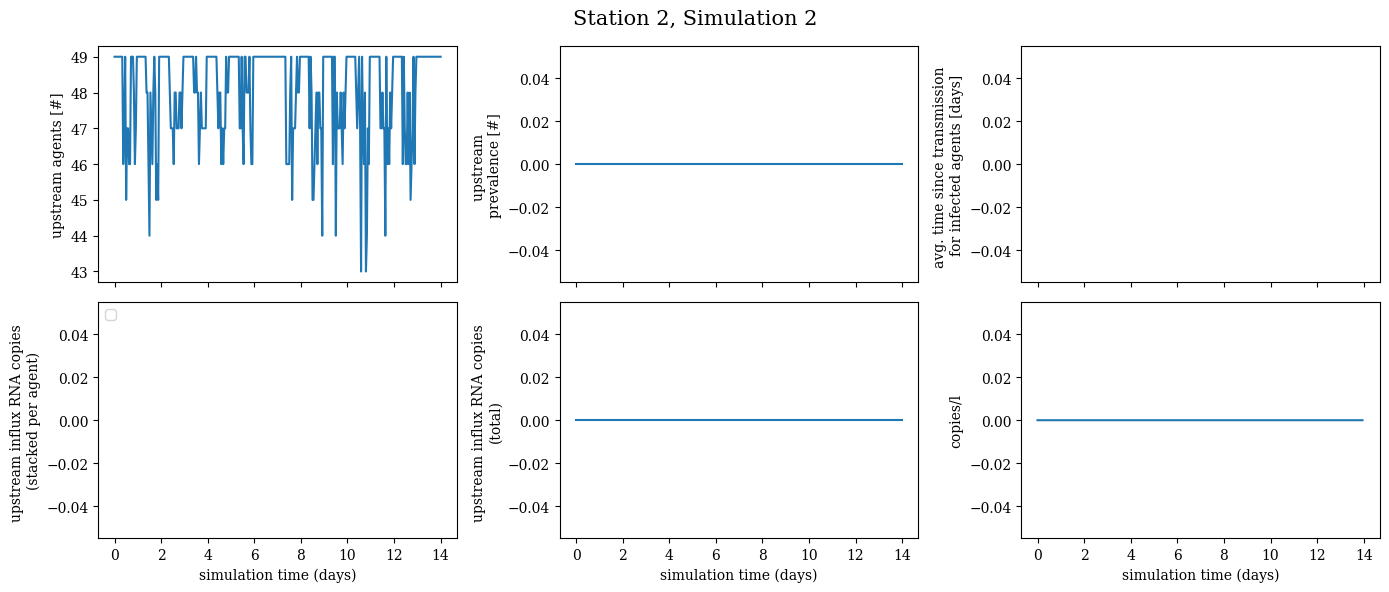

In [117]:
fig, axs = plt.subplots(2, 3, figsize=(14, 6), sharex=True)

# prevalence (equals number of upstream infections here)
sns.lineplot(upstream_prevalence, x="time_in_days", y="n_infections", ax=axs[0,1])
axs[0,1].set_ylabel("upstream \nprevalence [#]")

# time since transmission
sns.lineplot(avg_times_since_transmission, x="time_in_days", y="time_since_transmission", ax=axs[0, 2])
axs[0, 2].set_ylabel("avg. time since transmission \nfor infected agents [days]")

# upstream influx RNA per agent
x = stacked_shedding.time_in_days.unique()
y = [stacked_shedding.loc[stacked_shedding.agent_id==agent_id, "shedding"].values for agent_id in infected_agent_ids]
axs[1,0].stackplot(x,y, labels=[f"agent {int(i)}" for i in infected_agent_ids], colors=sns.color_palette("Pastel1")) # [sns.color_palette("Pastel1")[i] for i in [0, 2, 3, 4, 5, 6, 7, 8]])
axs[1,0].legend(loc='upper left')
axs[1,0].set_xlabel(f"simulation time (days)")
axs[1,0].set_ylabel("upstream influx RNA copies \n(stacked per agent)")

# upstream influx RNA
sns.lineplot(data=total_shedding, x="time_in_days", y="shedding", ax=axs[1,1])
axs[1,1].set_xlabel(f"simulation time (days)")
axs[1,1].set_ylabel("upstream influx RNA copies \n(total)")

# upstream agents
sns.lineplot(data=upstream_agents, x="time_in_days", y="n_agents", ax=axs[0,0])
axs[0,0].set_xlabel(f"simulation time (days)")
axs[0,0].set_ylabel("upstream agents [#]")

# concentration
df_conc_sub["time_in_days"] = (df_conc_sub["time"]-df_conc_sub["time"].min()).dt.total_seconds()/(24*60*60)
sns.lineplot(data=df_conc_sub, x="time_in_days", y="copies/l", ax=axs[1,2])
axs[1,2].set_xlabel(f"simulation time (days)")
axs[1,2].set_ylabel("copies/l") #  for infected agents

# axs[1,0].set_visible(False)

fig.suptitle(f'Station {sampling_point}, Simulation {simulation_id}', fontsize=15)
plt.tight_layout()

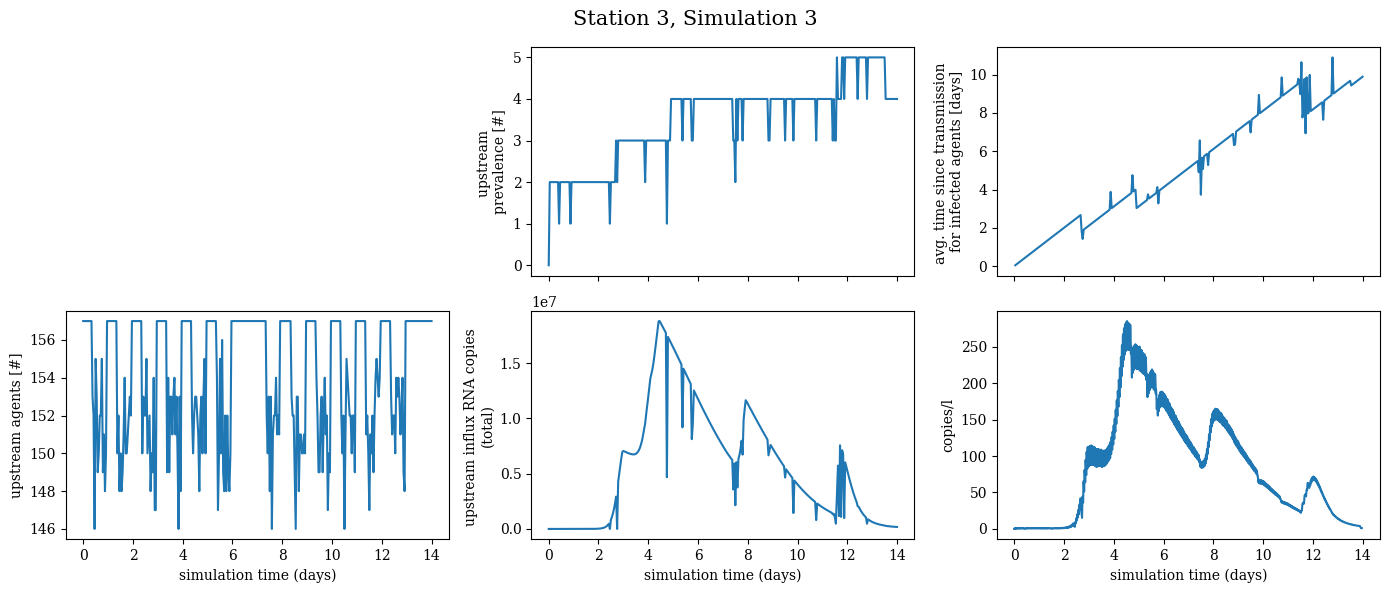

In [110]:
fig, axs = plt.subplots(2, 3, figsize=(14, 6), sharex=True)

# prevalence (equals number of upstream infections here)
sns.lineplot(upstream_prevalence, x="time_in_days", y="n_infections", ax=axs[0,1])
axs[0,1].set_ylabel("upstream \nprevalence [#]")

# time since transmission
sns.lineplot(avg_times_since_transmission, x="time_in_days", y="time_since_transmission", ax=axs[0, 2])
axs[0, 2].set_ylabel("avg. time since transmission \nfor infected agents [days]")

# upstream influx RNA
sns.lineplot(data=total_shedding, x="time_in_days", y="shedding", ax=axs[1,1])
axs[1,1].set_xlabel(f"simulation time (days)")
axs[1,1].set_ylabel("upstream influx RNA copies \n(total)")

# upstream agents
sns.lineplot(data=upstream_agents, x="time_in_days", y="n_agents", ax=axs[1,0])
axs[1,0].set_xlabel(f"simulation time (days)")
axs[1,0].set_ylabel("upstream agents [#]")

# concentration
df_conc_sub["time_in_days"] = (df_conc_sub["time"]-df_conc_sub["time"].min()).dt.total_seconds()/(24*60*60)
sns.lineplot(data=df_conc_sub, x="time_in_days", y="copies/l", ax=axs[1,2])
axs[1,2].set_xlabel(f"simulation time (days)")
axs[1,2].set_ylabel("copies/l") #  for infected agents

axs[0,0].set_visible(False)

fig.suptitle(f'Station {sampling_point}, Simulation {simulation_id}', fontsize=15)
plt.tight_layout()

### Analysis averaged over all simulations

In [15]:
df_infections_total = pd.read_csv("memilio_output/preprocessed/combined_infections_per_location.txt", index_col=0, dtype={"systems_location": str})

/tmp/ipykernel_91699/3738167808.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


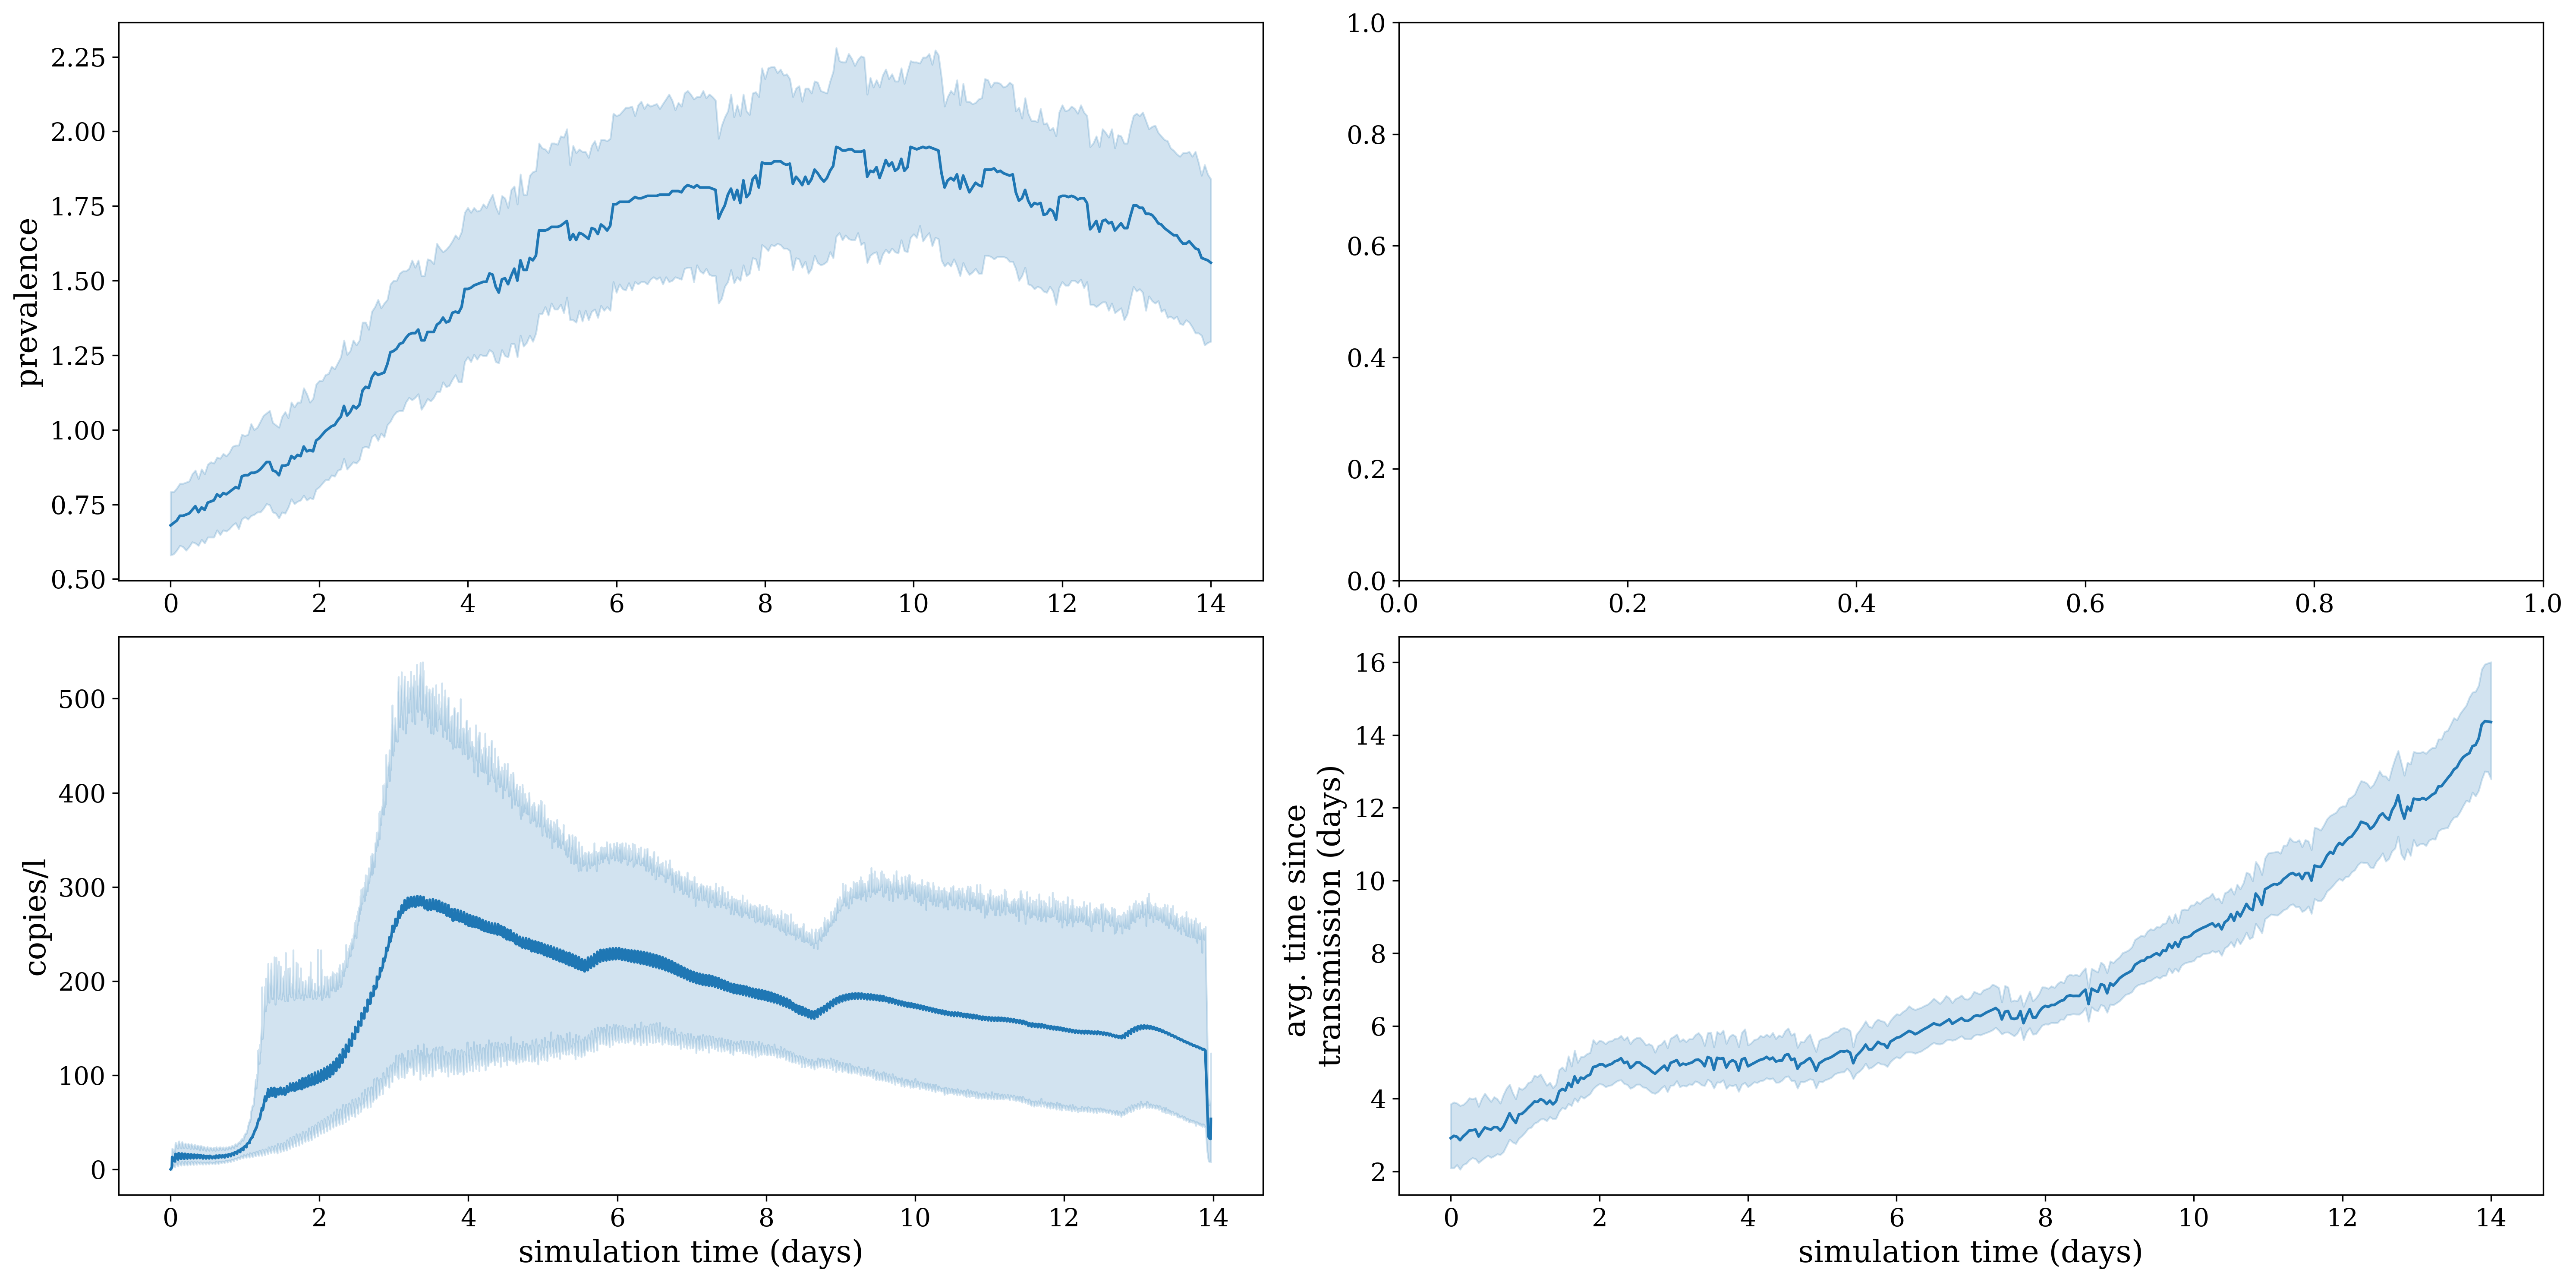

In [39]:
sampling_location = "1"
upstream_locations = upstream_locations_dict[sampling_location]
df_conc_sub = df_conc.loc[(df_conc.sampling_point==sampling_location), :].copy()

upstream_infections = df_infections_total.loc[df_infections_total.systems_location.isin(upstream_locations)].copy()
# For each simulation id and location we have the average time since transmission.
# We now want to calculate the average over several locations -> 1. calculate total -> 2. calculate average with new grouping information
upstream_infections.loc[:,"total_times_since_transmission"] = upstream_infections.loc[:,"n_agents"]*upstream_infections.loc[:,"avg_times_since_transmission"]
upstream_infections = upstream_infections.groupby(["time_in_days", "simulation_id"]).sum().reset_index()[["simulation_id", "time_in_days", "n_infections", "n_agents", "total_times_since_transmission"]]
upstream_infections.loc[:,"avg_times_since_transmission"] = upstream_infections.loc[:,"total_times_since_transmission"]/upstream_infections.loc[:,"n_infections"]

date_form = DateFormatter("%-d")

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=False, sharex=False, figsize=(20,10), dpi=300)

# first column
upstream_infections["prevalence"] = upstream_infections["n_infections"]# /upstream_infections["n_agents"]
sns.lineplot(upstream_infections, x="time_in_days", y="prevalence", ax=axs[0,0])
axs[0,0].set_ylabel("prevalence", fontsize=17)
axs[0,0].set_xlabel("", fontsize=17)

sns.lineplot(data=df_conc_sub, x="time", y="copies/l", ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(date_form) 
axs[1,0].set_xlabel(f"simulation time (days)", fontsize=17)
axs[1,0].set_ylabel("copies/l", fontsize=17) #  for infected agents
axs[1,0].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])

# second column
sns.lineplot(upstream_infections, x="time_in_days", y="avg_times_since_transmission", ax=axs[1,1])
axs[1,1].set_ylabel("avg. time since \ntransmission (days)", fontsize=17) #  for infected agents
axs[1,1].set_xlabel("simulation time (days)", fontsize=17)


for i in range(2):
    for j in range(2):
        axs[i,j].tick_params(axis='x', labelsize=14)
        axs[i,j].tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig(os.path.join("systems_output", "plots",'prevalence_and_concentration_station_1.png'))